<center><h1> Import de librairies et fonctions</h1></center>

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import cm
from numpy import linalg as LA
import copy 
import sklearn.feature_extraction.image as sk_fe
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)
from sklearn.linear_model import (LinearRegression,Ridge, RidgeClassifierCV,
                                  LassoCV, Lasso,Ridge)
from sklearn.manifold import Isomap
import matplotlib.colors as colors
from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.feature_extraction.image import extract_patches_2d
from utils import *
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 


<center><h1> Partie I : Régression Linéaire, Régression Ridge et LASSO</h1></center>

<h4> Analyse de la base de données</h4>

In [2]:
datax_train, datay_train = load_usps("../res/USPS/USPS_train.txt")
datax_test, datay_test = load_usps("../res/USPS/USPS_test.txt")

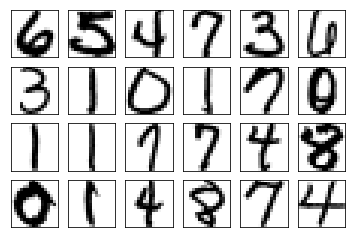

In [3]:
fig, axe = plt.subplots(4, 6, subplot_kw=dict(xticks=[], yticks=[]))
for i in range(len(axe.flat)):
    (axe.flat)[i].imshow(datax_train[i].reshape(16, 16), cmap='gray_r')

Nous souhaitons représenter ces données --> reduction de dimension
https://prateekvjoshi.com/2014/06/21/what-is-manifold-learning/
1/How do we reduce the dimensionality?
2/What exactly is manifold learning?


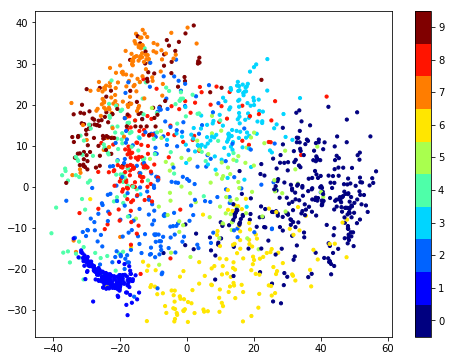

In [4]:
# Projection des données en 2 dimensions
model = Isomap(n_components=2)
projection = model.fit_transform(datax_train[0:1500,:])

# Affichage
plt.figure(figsize=(8,6))
plt.scatter(projection[:, 0], projection[:, 1], s=10, c=datay_train[0:1500], cmap=plt.cm.get_cmap('jet', 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)

Dans la figure ci-dessus, nous avons projeté les données en deux dimensions. Cette représentation nous permet facilement d'analyser les données et de voir visualement les données qui sembleraient corrélées. 

Nous pouvons remarquer que les distributions du chiffre 6 et 7 sont très éloignées. Alors, nous concluons que les chiffres 6 et 7 ne possèdent pas les mêmes caractéristques. Pour préciser, nous dirons que les écritures manuscrites de ces deux chiffres est très différente. 

Plus loin,  nous considérons les chiffres 3 et 8. Les distributions de ces chiffres sont confondues. Pour interpréter ce résutlat, nous pouvons imaginer que l'écriture manuscrite du chiffre 3 représente la moitité de celle du chiffre 8 de façon verticale. D'où la forte corrélation qui existe entre les chiffres 3 et 8.

#### Expérimentations

Maitenant, nous allons mettre en pratique les trois algorithmes de régularisation suivants:
- La régression linéaire.
- La régression ridge.
- Le lasso. 

Pour ce faire, nous considérons le jeu de donnée USPS sur lequel nous allons appliquer les trois variantes précédentes. Puis, nous allonrs comparer les résultats.

Lorsque nous appliquons une régularisation, nous réduisons la variance des estimations. Cependant, si nous considérons une valeur très grande, nous obtenons une régularisation sévère. 

In [5]:
trainx6_9, trainy6_9 =filter_oneVsone(datax_train, datay_train, 6,9)
testx6_9, testy6_9 = filter_oneVsone(datax_test, datay_test, 6,9)

In [6]:
def sklearn_model(trainx,trainy,testx,testy,model,alpha=0,max_iter=10000):
    myModel=model()
    myModel.fit(trainx,trainy)
    myModel_w=myModel.coef_
    testy_predicted = myModel.predict(testx)
    sc=score(testy,testy_predicted)
    error= np.mean((testy_predicted-testy) ** 2)
    return myModel_w,sc,error

### Regression linéaire

In [7]:
linear_w,linear_sc,error=sklearn_model(trainx6_9, trainy6_9,testx6_9, testy6_9,LinearRegression)
print("Regression linéaire")
print("Score en test: {:.3f}".format(linear_sc))
print("Erreur: ",error)

Regression linéaire
Score en test: 0.500
Erreur:  88.593426801


### Regression ridge


In [8]:
ridge_w,ridge_sc,error=sklearn_model(trainx6_9, trainy6_9,testx6_9, testy6_9,Ridge,alpha=0.01)
print("Regression ridge")
print("Score en test: {:.3f}".format(ridge_sc))
print("Erreur: ",error)

Regression ridge
Score en test: 0.500
Erreur:  0.0808578607581


### Algorithme du LASSO

In [9]:
lasso_w,lasso_sc,error=sklearn_model(trainx6_9, trainy6_9,testx6_9, testy6_9,Lasso,alpha=1e-15)
print("Algorithme du LASSO")
print("Score en test: {:.3f}".format(lasso_sc))
print("Erreur: ",error)

Algorithme du LASSO
Score en test: 0.490
Erreur:  1.00085070858


### Effets du paramètre α sur le vecteur de poids W
Nous allons entrainer nos modèles: Ridge regression et Lasso sur les données limitées aux chiffres 6 et 9. Dans cette expérience, nous allons varier les valeurs du paramètre α afin de voir son effet sur le vecteur des poids W. Le but de notre expérience est donc de trouver un coefficient de régularisation adapté à notre problème.


In [10]:
alphas=[1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,2,5]
ridge_error=[]
count0_rid=[]
ridge_ws=[]
for alp in alphas:
    l=Ridge(alpha=alp,max_iter=50000)
    l.fit(trainx6_9,trainy6_9)
    rid_w=l.coef_
    testy_predicted = l.predict(testx6_9)
    ridge_error.append(np.mean((testy_predicted-testy6_9) ** 2))
    sc=score(testy6_9,testy_predicted)
    count0_rid.append(np.count_nonzero(rid_w))
    ridge_ws.append(LA.norm(rid_w))
count0_lasso=[]
lasso_ws=[]
lasso_error=[]
for alp in alphas:
    l=Lasso(alpha=alp,max_iter=50000)
    l.fit(trainx6_9,trainy6_9)
    lasso_w=l.coef_
    testy_predicted = l.predict(testx6_9)
    lasso_error.append(np.mean((testy_predicted-testy6_9) ** 2))
    sc=score(testy6_9,testy_predicted)
    count0_lasso.append(np.count_nonzero(lasso_w))
    lasso_ws.append(LA.norm(lasso_w))

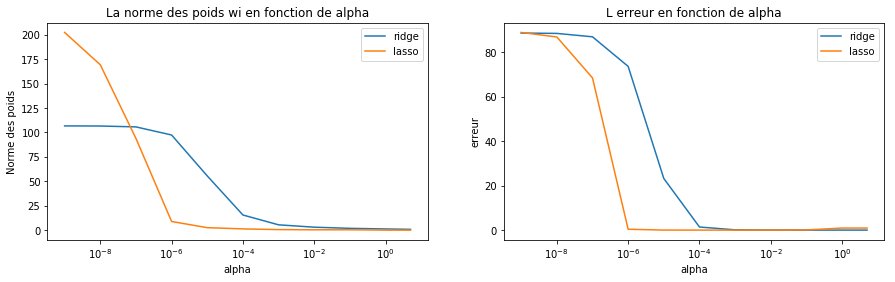

In [11]:
fig=plt.figure(figsize=(15, 4))
fig.add_subplot(1, 2, 1)

ax = plt.gca()
ax.plot(alphas, ridge_ws,label='ridge')
ax.plot(alphas, lasso_ws,label='lasso')

ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('Norme des poids')
plt.title('La norme des poids wi en fonction de alpha')
plt.axis('tight')
plt.legend()

fig.add_subplot(1, 2, 2)
ax = plt.gca()
ax.plot(alphas, ridge_error,label='ridge')
ax.plot(alphas, lasso_error,label='lasso')

ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('erreur')
plt.title('L erreur en fonction de alpha')
plt.axis('tight')
plt.legend()

plt.show()

In [12]:
i = np.where(ridge_error==min(ridge_error))[0][0]
ridge_alpha=alphas[i]
print("Best Ridge erreur:",ridge_error[i],"pour alpha:",alphas[i])

Best Ridge erreur: 0.0768405015857 pour alpha: 5


In [13]:
i = np.where(lasso_error==min(lasso_error))[0][0]
lasso_alpha=alphas[i]
print("Best Lasso erreur:",lasso_error[i],"pour alpha:",alphas[i])

Best Lasso erreur: 0.0733614758067 pour alpha: 0.001


##### Analyse
Après avoir effectué des essais en variant la valeur alpha, nous remarquons que la régularisation appliquée a diminué l'erreur. Nous obsevons que:
- Pour la regression ridge, nous nous retrouvons avec une erreur de 0.0768 avec alpha=5.
- Pour le lasso, nous nous retrouvons avec une erreur de 0.0733 avec alpha=0.001.

###### Effets de alpha sur les composantes
Maintenant, nous allons étudier l'effet des valeurs de alpha sur les composantes. 

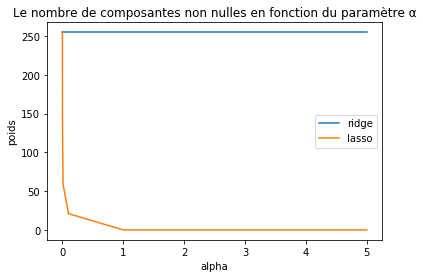

In [14]:
plt.plot(alphas,count0_rid,label='ridge')
plt.plot(alphas,count0_lasso,label='lasso')
plt.xlabel('alpha')
plt.ylabel('poids')
plt.legend()
plt.title("Le nombre de composantes non nulles en fonction du paramètre α")
plt.show()

###### Analyse
À partir de la figure ci-dessus, α pourrait faire partie de trois classes pour le ridge:
- α = 0: dans ce cas, nous retourvons la regréssion linéaire. 
- α --> ∞: dans ce cas, il y a une très grande restriction sur la valeur des poids. Nous remarsuons que les poids s'annulent. Ceci est dû à la pondération infinie sur le carré des poids.
- 0 < α < ∞: ceci représente le cas où les poids ne sont pas nuls. 

Si certaines variables sont correllées, le lasso effectue une séléction contrairement au ridge. Le lasso annule le poids d'une de ces variables et selectionne l'autre. 

In [15]:
rid_w,ridge_sc,error=sklearn_model(trainx6_9, trainy6_9,testx6_9, testy6_9,Ridge,alpha=ridge_alpha)
lasso_w,lasso_sc,error=sklearn_model(trainx6_9, trainy6_9,testx6_9, testy6_9,Lasso,alpha=0.00000001)

In [16]:
l=Ridge(alpha=ridge_alpha, max_iter=1000)
l.fit(trainx6_9,trainy6_9)
rid_w=l.coef_
testy_predicted = l.predict(testx6_9)
ridge_error.append(np.mean((testy_predicted-testy6_9) ** 2))
sc=score(testy6_9,testy_predicted)
count0_rid.append(np.count_nonzero(rid_w))
ridge_ws.append(LA.norm(rid_w))
count0_lasso=[]
lasso_ws=[]
lasso_error=[]

l=Lasso(alpha=lasso_alpha, max_iter=1000)
l.fit(trainx6_9,trainy6_9)
lasso_w=l.coef_
testy_predicted = l.predict(testx6_9)
lasso_error.append(np.mean((testy_predicted-testy6_9) ** 2))
sc=score(testy6_9,testy_predicted)
count0_lasso.append(np.count_nonzero(lasso_w))
lasso_ws.append(LA.norm(lasso_w))

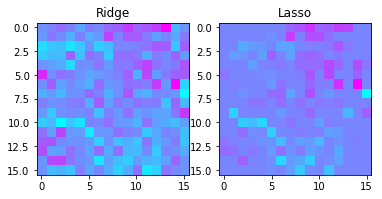

In [17]:
fig=plt.figure()
fig.add_subplot(1, 2, 1)
plt.title("Ridge")
plt.imshow(rid_w.reshape(16,16),cmap='cool')
fig.add_subplot(1, 2, 2)
plt.title("Lasso")
plt.imshow(lasso_w.reshape(16,16),cmap='cool')
plt.show()

##### Bilan
Gardez à l'esprit que la régression de crête ne peut pas mettre à zéro les coefficients; ainsi, vous finissez par inclure tous les coefficients du modèle ou aucun d'entre eux. Cependant, le Lasso effectue la réduction de paramètre et la sélection de variable automatiquement. 

- Le lasso ne garde pas toutes les données. Si deux variables sont très corrélées, il en garde qu'une Il supprime celles qui ne contribuent pas à la sortie. Ceci permet basiquement de mieux interpréter le modèle. Par cons

- En ce qui concerne les variables très correlées, le Lasso ne considère qu'une parmi les deux.


<center><h1> Partie II : LASSO et Inpainting</h1></center>

L'inpainting d'image consiste à reconstituer les parties manquantes d'une image de sorte que les régions restaurées soient led plus naturelles. Cette technique est souvent utilisée pour supprimer des objets indésirables d'une image ou pour restaurer des parties endommagées de vieilles photos. 

Dans cette deuxième partie du projet, nous partons d'une image complète. Puis, nous allons bruiter cette image de façon à perdre des parties de l'images (pixel ou patch). Ensuite, nous allons essayer de restaurer ces parties manquantes en utilisant le Lasso.

Hypothèse de l'énoncé: nous allons considérer qu’une grande partie de l’image n’a pas de pixels manquants.

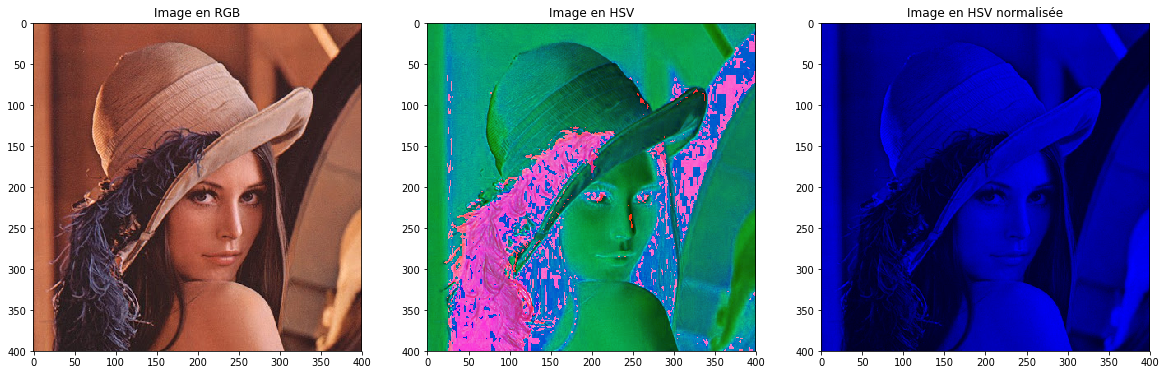

In [18]:
im_rgb,im_hsv,im_hsv_norm=read_im("../res/lena.jpg")
fig=plt.figure(figsize=(20, 8))
fig.add_subplot(1, 3, 1)
plt.title("Image en RGB")
plt.imshow(im_rgb)
fig.add_subplot(1, 3, 2)
plt.title("Image en HSV")
plt.imshow(im_hsv)
fig.add_subplot(1, 3, 3)
plt.title("Image en HSV normalisée")
plt.imshow(im_hsv_norm)


Nous allons commencer par étudier l'image de Léna et effectuer dessus des opérations de bruitage. Puis, nous allons tester l'efficacité des implémentées sur d'autres instances. 

#### Test sur un dictionnaire issu de l’image complète non bruitée
Tout d'abord, nous allons tester sur l'image originale sans la bruiter

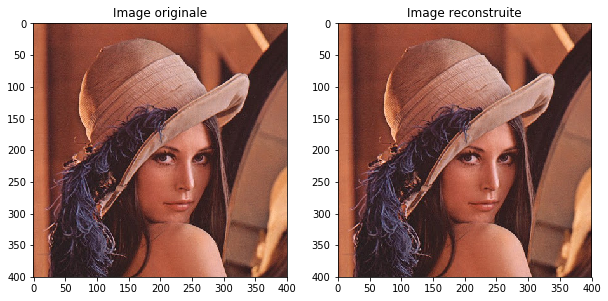

In [19]:
step=20
h=40
patches=get_patches(im_rgb,step,h)
patches_comp=getPatches_comp(patches)
data_train=build_data_train(im_rgb,patches_comp,step,h)
model = Lasso(max_iter=2000)
model.fit(data_train[0],data_train[1])
new_img=reconstruct_im(model,im_rgb,h )
fig=plt.figure(figsize=(10, 8))
fig.add_subplot(1, 2, 1)
plt.title("Image originale")
plt.imshow(normalize(im_rgb))
fig.add_subplot(1, 2, 2)
plt.title("Image reconstruite")
plt.imshow(normalize(new_img))
plt.show()

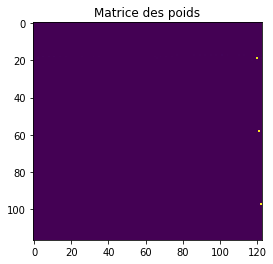

In [20]:
plt.imshow(model.coef_.reshape((117,123)))
plt.title("Matrice des poids")
plt.show()

Nous remarquons que la matrice des poids n'est pas tout à fait à nul, comme on devait s'y attendait. Or, nous remarquons quelques points jaunes sur la matrice. Nous pensons que ceci est dû au choix de la valeur de bruit à rajouter dans l'image, soit de (253,253,253). Donc, l'algorithme l'avait considée comme du bruit. Par conséquent, il a cherché à compléter le pixel portant cette valeur.

#### Test sur un dictionnaire issu de l’image complète bruitée
Maintenant, nous allons bruiter l'image de Léna avec un pourcentage de 20%. Nous commençons avec un petit pourcentage pusique l'énoncé exige qu'une grande partie de l'image soit complète.

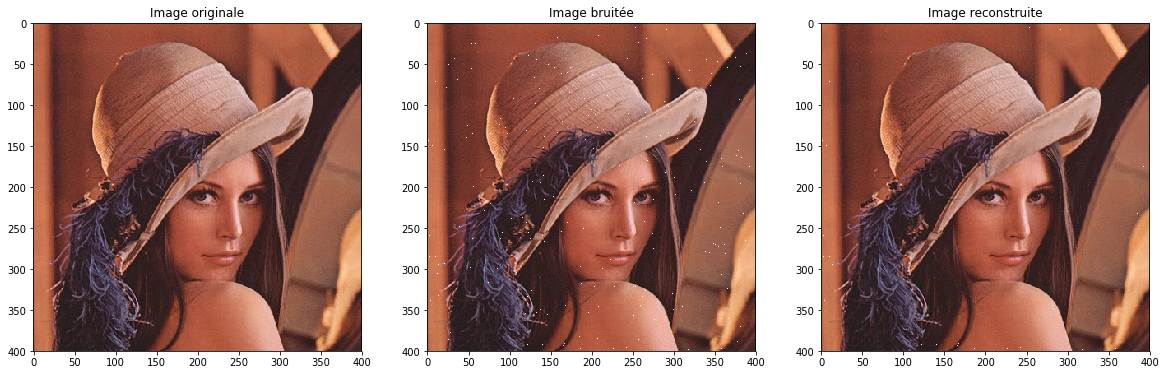

In [21]:
step=20
h=20
image_noisy=noise(im_rgb,0.2)
patches=get_patches(image_noisy,step,h)
patches_comp=getPatches_comp(patches)
data_train=build_data_train(image_noisy,patches_comp,step,h)
model = Lasso(max_iter=2000)
model.fit(data_train[0],data_train[1])
new_img=reconstruct_im(model,image_noisy,h )
fig=plt.figure(figsize=(20, 8))
fig.add_subplot(1, 3, 1)
plt.title("Image originale")
plt.imshow(normalize(im_rgb))
fig.add_subplot(1, 3, 2)
plt.title("Image bruitée")
plt.imshow(normalize(image_noisy))
fig.add_subplot(1, 3, 3)
plt.title("Image reconstruite")
plt.imshow(normalize(new_img))
plt.show()

Nous constatons que l'algorithme a atténué une très grande majorité du bruit rajouté. Sauf, pour quelques pixels sir les bordures.

#### Test en particulier sur un patch sans bruit
Dans cette partie, nous allons étudier particulièrement les patchs. Nous allons prendre un patch de l'image de Léna, le bruiter et analyser les résultats obtenus. 
Nous avons choisi un patch qui contient le plus de contours, de détails et de changement de couleurs. 

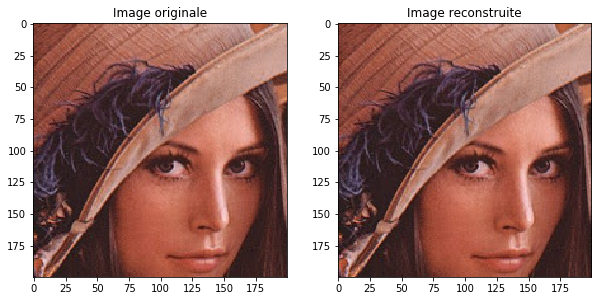

In [22]:
patch=get_patch(200,200,200,im_rgb)
step=20
h=10
patches=get_patches(patch,20,10)
patches_comp=getPatches_comp(patches)
data_train=build_data_train(image_noisy,patches_comp,step,h)
model = Lasso(max_iter=3000)
model.fit(data_train[0],data_train[1])
new_img=reconstruct_im(model,patch,10 )
fig=plt.figure(figsize=(10, 8))
fig.add_subplot(1, 2, 1)
plt.title("Image originale")
plt.imshow(patch)
fig.add_subplot(1, 2, 2)
plt.title("Image reconstruite")
plt.imshow(new_img)
plt.show()

#### Test en particulier sur un patch  avec du bruit
Nous allons effectuer un bruit de 90%, dans le but de pousser la méthode à sa limite.

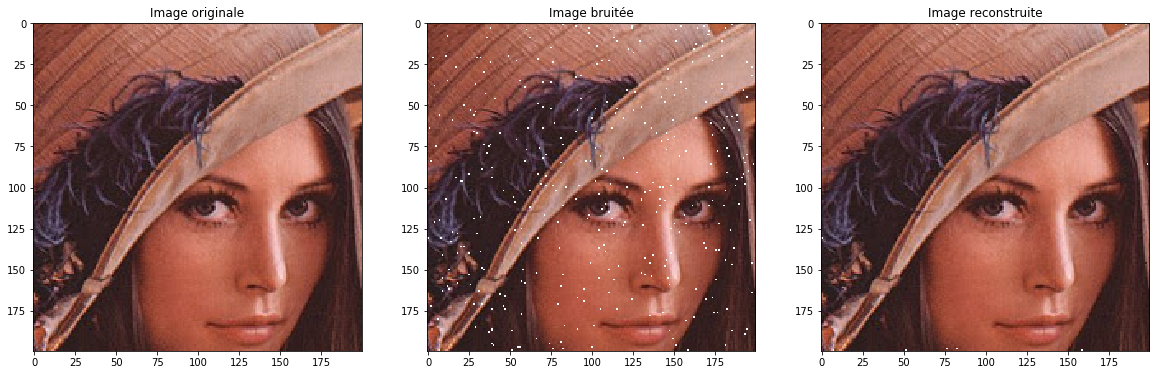

In [23]:
step=4
h=4
patch_noisy=noise(patch,0.9)
patches=get_patches(patch_noisy,step,h)
patches_comp=getPatches_comp(patches)
data_train=build_data_train(patch_noisy,patches_comp,step,h)
model = Lasso()
model.fit(data_train[0],data_train[1])
new_img=reconstruct_im(model,patch_noisy,h )
fig=plt.figure(figsize=(10, 8))
fig=plt.figure(figsize=(20, 8))
fig.add_subplot(1, 3, 1)
plt.title("Image originale")
plt.imshow(normalize(patch))
fig.add_subplot(1, 3, 2)
plt.title("Image bruitée")
plt.imshow(normalize(patch_noisy))
fig.add_subplot(1, 3, 3)
plt.title("Image reconstruite")
plt.imshow(normalize(new_img))
plt.show()

Nous avons obtenu un résultat assez satisfaisant, mis à part pour quelques pixels sur les bordues. Ce résultat a été obtenu en fixant le step et la fenêtre à 4. 

Dans ce cas, la petite fenêtre était le meilleur choix à considérer, car comme l'image contient beaucoup de détails une grande fenêtre pourrait envelopper des pixels indésirables. Ces pixels indésirables pourraient appartenir par exemple à la partie des cheveux, pendant que nous cherchons à prédire les pixels au niveau du chapeau.

Le step fixé à 4 permet une meilleure précision.

#### Test en particulier sur une image avec un patch manquant
Maintenant,nous allons supprimer toute une partie entière de l'image de Léna et analyser l'efficacité de la méthode développée.

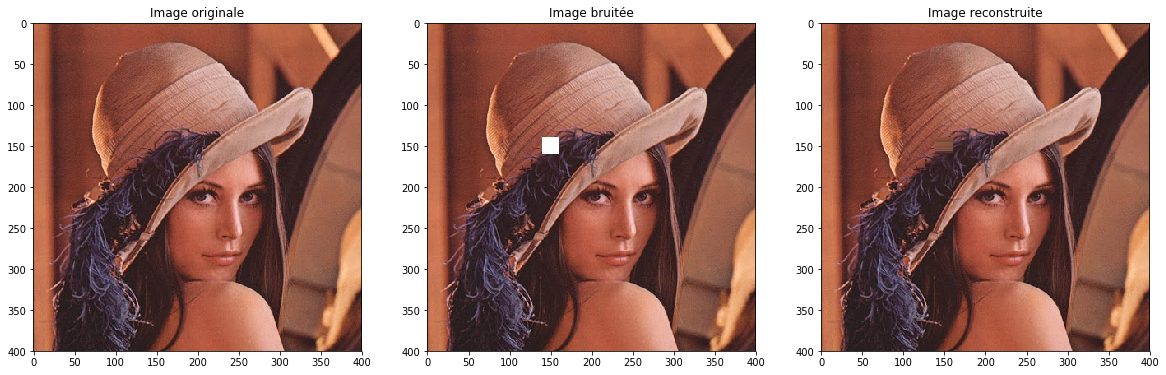

In [24]:
image=delete_rect(im_rgb,150,150,20,20)
step=20
h=40
patches=get_patches(image,step,h)
patches_comp=getPatches_comp(patches)
data_train=build_data_train(image,patches_comp,step,h)
model = Lasso(max_iter=2000)
model.fit(data_train[0],data_train[1])
new_img=reconstruct_im(model,image,h )
fig=plt.figure(figsize=(20, 8))
fig.add_subplot(1, 3, 1)
plt.title("Image originale")
plt.imshow(normalize(im_rgb))
fig.add_subplot(1, 3, 2)
plt.title("Image bruitée")
plt.imshow(normalize(image))
fig.add_subplot(1, 3, 3)
plt.title("Image reconstruite")
plt.imshow(normalize(new_img))
plt.show()

À ce stade, nous remarqons une reconstruction de l'image pas très satisfaisante. En particulier, la partie du chapeau à été plus ou moins bien reproduite. Or, nous remarquons que les pixels manquants à la partie du des cheveux ont pris la même couleur du chapeau. 

Cette reconstruction nous montre que l'ordre dans lequel on remplit notre image possède un très grand impact sur le résultat. Ceci est dû au fait que les pixels au niveau du chapeau se remplissent avant les pixels au niveau du cheveux. Donc, au remplissage des pixels au niveau des cheveux, le patch considéré sur ces patchs est fortement influencé par les pixels reconsitués du chapeau.

#### Proposition d'une heuristique intelligente

Dans cette partie, nous proposons une heurstique qui permetterait de remplir de manière plus intelligente que la méthode précédente et de considérer l'ordre dans lequel les pixels doivent se remplir:

1/ Détecter la présence d'un patch manquant M.

2/ À chaque itération remplir les bordures du patch en fonction des pixels environnants.

Critère d'arrêt: lorsque l'on arrive à remplir le centre de l'image.

Le remplissage des pixels sur les bordures s'effectue de cette marnière:
1/ Considérer un patch P avec comme centre le pixel p à prédire.
2/ Nous pouvons voir ce patch P sous forme de deux "L" dont l'un à lenvers. Un premier "L" se situerait à l'intérieur du patch manquant M à prévoir. Ce "L" contient donc que des pixels manquants. Nous supprimons toutes ces valeurs manquantes de ce patch, sinon ça fausserait la prédiction. Nous gardons alors, uniquement les pixels vivants (non manquants).  

Or, lorsque l'on supprime ces valeurs, la taille du patch change. Pour palier à ce problème, nous calculons la médiane des pixels vivants et nous complétons le patch P avec cette médiane jusqu'à atteindre sa taille de départ.

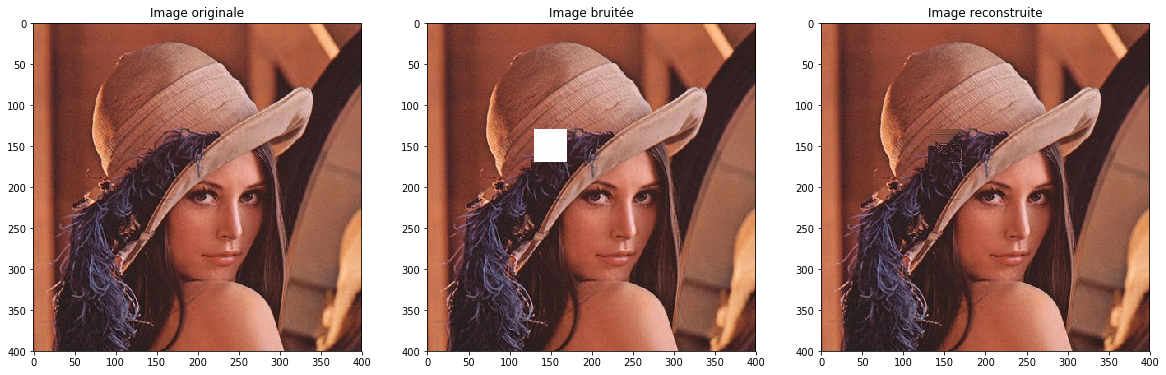

In [25]:
image=delete_rect(im_rgb,150,150,40,40)
step=40
h=40
patches=get_patches(image,step,h)
patches_comp=getPatches_comp(patches)
data_train=build_data_train(image,patches_comp,step,h)
model = Lasso(max_iter=5000)
model.fit(data_train[0],data_train[1])
new_img=reconstruct_im_rec(model,image,h,150,150 )
fig=plt.figure(figsize=(20, 8))
fig.add_subplot(1, 3, 1)
plt.title("Image originale")
plt.imshow(normalize(im_rgb))
fig.add_subplot(1, 3, 2)
plt.title("Image bruitée")
plt.imshow(normalize(image))
fig.add_subplot(1, 3, 3)
plt.title("Image reconstruite")
plt.imshow(normalize(new_img))
plt.show()

## Expérimentations
Pour s'assurer de l'efficacité de notre heuristique développée, nous l'avons testés sur d'autres images pour voir comment est-ce que cette heuristique se comporte sous d'autres contraintes. Nous avons obtenus les résultats suivants qui restent suffisamment acceptables:

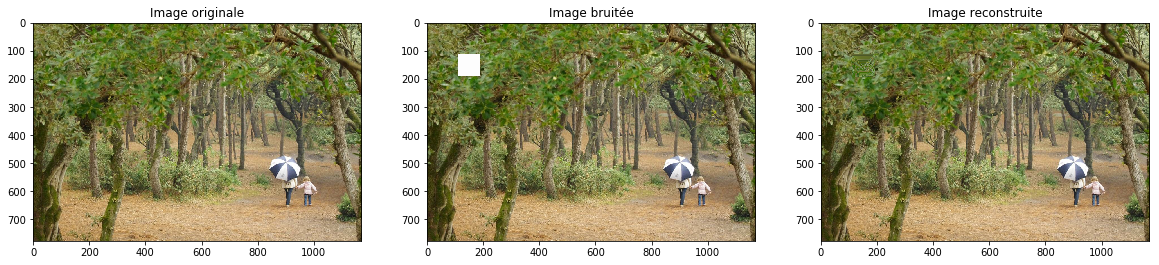

In [26]:
im_rgb,im_hsv,im_hsv_norm=read_im("../res/foret.jpg")
image=delete_rect(im_rgb,150,150,80,80)
step=80
h=80
patches=get_patches(image,step,h)
patches_comp=getPatches_comp(patches)
data_train=build_data_train(image,patches_comp,step,h)
model = Lasso(max_iter=5000)
model.fit(data_train[0],data_train[1])
new_img=reconstruct_im_rec(model,image,h,150,150 )
fig=plt.figure(figsize=(20, 8))
fig.add_subplot(1, 3, 1)
plt.title("Image originale")
plt.imshow(normalize(im_rgb))
fig.add_subplot(1, 3, 2)
plt.title("Image bruitée")
plt.imshow(normalize(image))
fig.add_subplot(1, 3, 3)
plt.title("Image reconstruite")
plt.imshow(normalize(new_img))
plt.show()

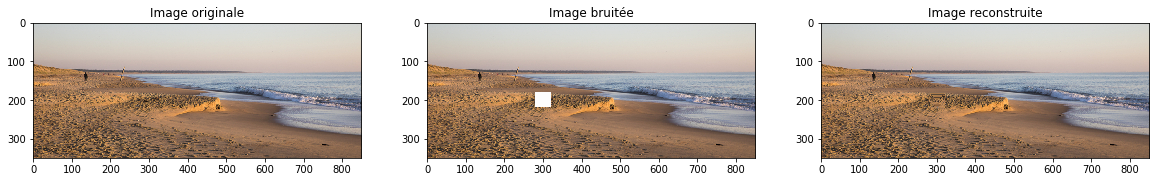

In [27]:
im_rgb,im_hsv,im_hsv_norm=read_im("../res/plage.jpg")
image=delete_rect(im_rgb,200,300,40,40)
step=40
h=40
patches=get_patches(image,step,h)
patches_comp=getPatches_comp(patches)
data_train=build_data_train(image,patches_comp,step,h)
model = Lasso(max_iter=5000)
model.fit(data_train[0],data_train[1])
new_img=reconstruct_im_rec(model,image,h,200,300)
fig=plt.figure(figsize=(20, 8))
fig.add_subplot(1, 3, 1)
plt.title("Image originale")
plt.imshow(normalize(im_rgb))
fig.add_subplot(1, 3, 2)
plt.title("Image bruitée")
plt.imshow(normalize(image))
fig.add_subplot(1, 3, 3)
plt.title("Image reconstruite")
plt.imshow(normalize(new_img))
plt.show()

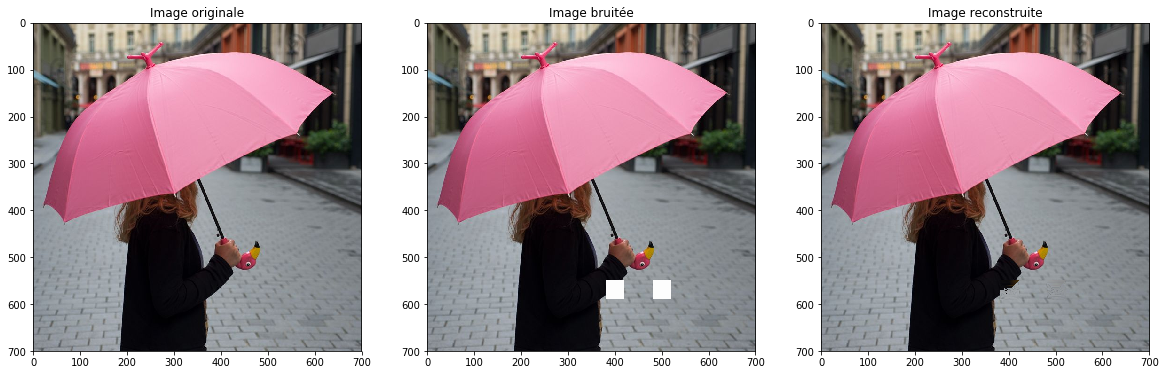

In [28]:
im_rgb,im_hsv,im_hsv_norm=read_im("../res/parapluie.jpg")
image=delete_rect(im_rgb,570,400,40,40)
image=delete_rect(image,570,500,40,40)
step=40
h=40
patches=get_patches(image,step,h)
patches_comp=getPatches_comp(patches)
data_train=build_data_train(image,patches_comp,step,h)
model = Lasso(max_iter=5000)
model.fit(data_train[0],data_train[1])
new_img=reconstruct_im_rec(model,image,h,570,400)
new_img=reconstruct_im_rec(model,new_img,h,570,500)
fig=plt.figure(figsize=(20, 8))
fig.add_subplot(1, 3, 1)
plt.title("Image originale")
plt.imshow(normalize(im_rgb))
fig.add_subplot(1, 3, 2)
plt.title("Image bruitée")
plt.imshow(normalize(image))
fig.add_subplot(1, 3, 3)
plt.title("Image reconstruite")
plt.imshow(normalize(new_img))
plt.show()

## Conclusion
- Cette heuristique développée pourrait avoir de meilleurs résultats si nous diminuons la taille de la fenêtre ou du step, et en effectuant le traitement sur une machine plus performante. Aussi, il pourrait être intéréssant de coder 3 Lasso, chacun sur une dimension, au lieu de d'un seul comme dans notre cas. 

- La technique du MiniBatchDictionaryLearning: La librairie Sklearn offre MiniBatchDictionaryLearning. Par conséquent, le travail effectué pourrait être amélioré. Une amélioration possible serait de chercher un le meilleur dictionnaire parmi d'autres qui peut être utilisé de manière optimale pour représenter des données à l'aide d'un code fragmenté.

#### Sources:
- http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
- http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html
- https://towardsdatascience.com/image-inpainting-humans-vs-ai-48fc4bca7ecc
- https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.MiniBatchDictionaryLearning.html